# 1. Motivation

## What is your dataset?

We chose to use a dataset found on kaggle. The dataset contains oscar nominations from 1927 - 2019 and it has seven columns which are:
- **year_film**: Year of movie
- **year_ceremony**: Year of ceremony
- **ceremony**: Number of ceremony
- **category**: Nomination category
- **name**: Name of nomination
- **film**: Movie title
- **winner**: If movie won nomination (true or false)

Then we used wikipedia to get top ten highest-grossing movies between 1990 - 2019 and for each movie we get director and actors. Then we combined those two to get the results we wanted to achieve.

## Why did you choose this/these particular dataset(s)?

We were quite fast to agree that we should do data analysis with movies, movies are interesting and there is quite a lot of different options when analysing movies. Then we used the internet to find some interesting dataset to combine with the movies on wikipedia. Later on we came across the dataset with oscar nominations, which we thought could be quite fun and intersting to use doing some analysis with the movies from wikipedia pages.

## What was your goal for the end user's experience?

The goal was to find out if there was some specific pattern when a movie wins an oscar award. Particulary we wanted to find out if there was some connection between gross and oscar awards, we wanted to find out which genre have won most oscars, which director and actor have won most oscars, which movie have won most oscars and then use the three movies that have won most oscars counting word frequency and creating word clouds. We also wanted to find out if there is some pattern in the manuscript of the three movies who have won most oscars by using sentiment analysis.

# 2. Basic stats. Let's understand the dataset better

In [5]:
from urllib.request import urlopen
import urllib.request
import json
import re
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)
import csv



from wordcloud import WordCloud

import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.probability import FreqDist
from nltk.text import TextCollection

from urllib.request import urlopen
import json
import urllib

from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk.corpus import state_union

from nltk import word_tokenize
from nltk import tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.stem import WordNetLemmatizer 

from PIL import Image as Imagex

from IPython.display import Image

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from nrclex import NRCLex

## Write about your choices in data cleaning and preprocessing

As a starting point, the wiki pages have been read. An example of the first read page is this https://en.wikipedia.org/wiki/1990_in_film. It's easy to see that if in the link you change 1990 with another year, it will give you the film with the highest gross in that year.

First, each of these pages for different years have been read and saved.

In [2]:
list_of_years=[]

for year in range(1990,2020):
    
    
    baseurl="https://en.wikipedia.org/w/api.php?"
    action="action=query"
    title= "titles=%s_in_film" % (year)
    content="prop=revisions&rvprop=content&rvslots=*"
    dataformat="format=json"
    query="%s%s&%s&%s&%s" % (baseurl, action, title, content, dataformat)
    #print(query)
    
    wikiresponse = urllib.request.urlopen(query)
    wikisource = wikiresponse.read()


    wikijson=json.loads(wikisource)
    
    
    filename="%s_list.txt" % (year)
    
    
    #here to make it quick we upload the pages in the zip file, this would be the code to read them.
    '''
    with open(filename, "w") as text_file:
        text_file.write("%s" % wikijson['query']['pages'])

    '''
    
    #in this list we contain the name of each file (and every file contains a different page dipending on the wikipage)
    list_of_years.append(filename)
    




Here from every page created before (example: from the 1990.txt that contains the wiki page 1990 in film) the 10 movies with the highest gross have been extracted.

Example: from 1990 (https://en.wikipedia.org/wiki/1990_in_film) it is going to extract from Ghost to Kindergarten Cop.

In [3]:
list_of_films=[]

for filename in list_of_years:
    
    list_per_year=[]
    
    
   
    for n in range(1,11):
            pattern="%s\\\\n\| \\\\'\\\\'\[\[(.*?)\]\]" % n
            
            #the pattern in 2015 films was different.
            pattern_2015="%s\\\\n\| scope=\"row\" style= \| \\\\'\\\\'\[\[(.*?)\]\]|%s\\\\n\| scope=\"row\" \| \\\\'\\\\'\[\[(.*?)\]\]" % (n,n)
            
            

            # Open file
            f = open(filename, 'r').read()
            # Feed the file text into findall(); it returns a list of all the found strings
            foundings = re.findall(pattern,f)
            
            
            if filename=='2015_list.txt':
                foundings=re.findall(pattern_2015,f)
                
                if len(foundings[0][0])==0:
                    foundings[0]=foundings[0][1]
                else:
                    foundings[0]=foundings[0][0]
            
            
            if '|' in foundings[0]:
                    
                    film=foundings[0].split("|")
                    film=film[0]

            else:
                    film=foundings[0]

                    
            

            #print(film)


            
            if film not in list_of_films:
                        list_of_films.append(film)  
                        list_per_year.append(film)

            
    
    if len(list_per_year)!=10:
        print(list_per_year, '   ', filename)
    
years=[]
starter=1990
for g in range(0,30):
    
    for y in range(0,10):
        years.append(starter)
    starter=starter+1
    

#here you have the final dataframe
data_film = pd.DataFrame(zip(list_of_films, years) , columns = ['Name', 'year'])

Let's see the dataset at this point:

In [4]:
data_film

,Name,year
0,Ghost (1990 film),1990
1,Home Alone,1990
2,Pretty Woman,1990
3,Dances with Wolves,1990
4,Total Recall (1990 film),1990
...,...,...
295,Joker (2019 film),2019
296,Star Wars: The Rise of Skywalker,2019
297,Toy Story 4,2019
298,Aladdin (2019 film),2019


For the aim of the project Name and year are not enough. Information about each film are needed. How can it be done? Every film's wiki page must be inspected: let's read and save them. 

For example, to have more information about the film Ghost, you need to go in its wiki page (https://en.wikipedia.org/wiki/Ghost_(1990_film)) and save it.

In [5]:
list_of_files=[]
for name in data_film.Name:
    
    if ' ' in name:
        name = name.replace(' ', '_')
        
    if name=='Harry_Potter_and_the_Sorcerers__Stone_(film)' :
        name='Harry_Potter_and_the_Philosopher\'s_Stone_(film)'
    if name =='Harry_Potter_and_the_Deathly_Hallows_-_Part_1':
        name=name.replace('-','–')
        
    if '\\' in name:
        name = name.replace('\\', '')
        

    
    
    baseurl="https://en.wikipedia.org/w/api.php?"
    action="action=query"
    title= "titles="
    content="prop=revisions&rvprop=content&rvslots=*"
    dataformat="format=json"
    
    query="%s%s&%s%s&%s&%s" % (baseurl, action, title, urllib.parse.quote_plus(name), content, dataformat)
    #print(query)
    if '-' in name:
        name=name.replace('-','–')
    
    #REDIRECT PART!!!!!!!
    
    pattern_redirect='REDIRECT \[\[(.*?)\]\]'

    wikiresponse = urllib.request.urlopen(query)
    wikisource = wikiresponse.read()

    wikijson=json.loads(wikisource)
    
    # Feed the file text into findall(); it returns a list of all the found strings      
    foundings = re.findall(pattern_redirect,str(wikijson))
    
    if len(foundings)==1:
        redirect=foundings[0]
        
        baseurl="https://en.wikipedia.org/w/api.php?"
        action="action=query"
        title= "titles="
        content="prop=revisions&rvprop=content&rvslots=*"
        dataformat="format=json"
        if ' ' in redirect:
            redirect = redirect.replace(' ', '_')
    
    
    
        query="%s%s&%s%s&%s&%s" % (baseurl, action, title, urllib.parse.quote_plus(redirect), content, dataformat)
        
        wikiresponse = urllib.request.urlopen(query)
        wikisource = wikiresponse.read()

        wikijson=json.loads(wikisource)
    
    #END OF REDIRECT PART!!!!!!
   
        
        
    path="./Movies/"
    text=".txt"
    if name=='Harry_Potter_and_the_Philosopher\'s_Stone_(film)':
        name='Harry_Potter_and_the_Sorcerers__Stone_(film)'
    if name =='Harry_Potter_and_the_Deathly_Hallows_–_Part_1':
        name=name.replace('–','-')
    
    
    g="%s%s%s" % (path, name, text)
    
    list_of_files.append(g)
    
    
    
    #the pages are already given in the zip file.
    '''
    with open(g, "w") as text_file:
        text_file.write("%s" % wikijson['query']['pages'])
        
    '''
        

Even here, the wikipages are already given in the zip file. There were some issues with the Harry Potter films that are going to be explained later on.

### AMAZING, NOW EVERY FILM HAS ITS OWN PAGE!!!

Now, to get the information about films, the wikipage of each film was read and Actors and Director are extracted.

But first, let's __create the nodes of the graph!__

In [6]:
G=nx.Graph()

for node, year in zip(data_film.Name, data_film.year):
    G.add_node(node)
    G.nodes[node]["year"]=year

Perfect! Now, let's discover the actors and the director for each film.

In order to do so, the saved page for each film are analysed and through some regular expression (explained later), you can get the directors and the actors. For instance, in Ghost (https://en.wikipedia.org/wiki/Ghost_(1990_film)) you see that the pattern of the page is: '__starring__' indicating the cast, '__directed by__' indicating the director. 

In [7]:

list_of_director=[]
list_of_actors=[]

for file, name in zip(list_of_files, list_of_films):
    
    
    list_of_director=[]
    list_of_actors=[]
    
    pages_path= "./Movies/"
    with open(file,"r") as f:
        
        node_description=f.read()
        
        direction_pattern=r'(?<=director)(.*?)(?=\\n\|)'
        
        
        if name=='Avatar (2009 film)' or name=='Titanic (1997 film)' :
            direction_pattern=r'(?<=director  )(.*?)(?=\\n\|)'
        if 'The Matrix' in name or name=='Bohemian Rhapsody (film)':
            direction_pattern=r'(?<=director)(.*?)(?=<)'
        director_pattern=r'\[\[(.*?)(?:\|.*?)?\]\]'
        
        cast_pattern=r'(?<=starring)(.*?)(?=\\n\|)'
        actors_pattern=r'\[\[(.*?)(?:\|.*?)?\]\]'
        
        
        direction = re.findall(direction_pattern,node_description)
        
        for d in range(0,1):
            directors = re.findall(director_pattern,direction[0])

            for director in directors:

                list_of_director.append(director)

            G.nodes[name]['Director']=list_of_director

        if name=='Saving Private Ryan' or name=='Jumanji: Welcome to the Jungle':
            cast_pattern=r'(?<=starring)(.*?)(?=\\n\| )'
        
        cast=re.findall(cast_pattern,node_description)
        
        for c in range(0,1):
            actors = re.findall(actors_pattern,cast[0])
            if name=='Jumanji: Welcome to the Jungle':
                actors = re.findall(actors_pattern,cast[1])
                actors=actors[0:6]
                

            for actor in actors:

                list_of_actors.append(actor)

            G.nodes[name]['Actors']=list_of_actors


Let's see how one of the node looks right now!

In [8]:
G.nodes['Ghost (1990 film)']

{'year': 1990,
 'Director': ['Jerry Zucker'],
 'Actors': ['Patrick Swayze', 'Demi Moore', 'Whoopi Goldberg', 'Tony Goldwyn']}

THIS IS __EXACTLY__ WHAT YOU CAN FIND HERE IN THE MAIN TABLE: https://en.wikipedia.org/wiki/Ghost_(1990_film).

### THE GRAPH NEEDS EDGES NOW.

how to do that? From each node (film) you can take a list of actors, if one of the other film shares one or more actors, that's an edge. For example, Ghost has 4 actors, a list of this 4 actors is therefore created. In an internal loop, all the other films are analyzed, once a time. For instance, with the pair (Ghost and A Few Good Man) you can see that they share only Demi Moore as a common actor: that's a link. If we take 2 film from the The Lord of Rings saga, we will see that they share 10/12 actors).

In [9]:
for g in G.nodes(data=True):
    
    actorsforfilm= g[1]['Actors']
        
    for f in G.nodes(data=True):
            list_of_links=[]
            if f!=g and G.has_edge(f[0], g[0])==False:
                
                for actor2 in f[1]['Actors']:
                    
                    if actor2 in actorsforfilm:
                        
                        list_of_links.append(actor2)
                        
                if len(list_of_links)!=0:
                    G.add_edge(g[0], f[0], Actors=set(list_of_links) ) 

Let's see an __example of an edge!__

In [10]:
list(G.edges(data=True))[0]

('Ghost (1990 film)', 'A Few Good Men', {'Actors': {'Demi Moore'}})

another example could be:

In [11]:
list(G.edges(data=True))[1039]

('X2 (film)',
 'X-Men: Days of Future Past',
 {'Actors': {'Anna Paquin',
   'Halle Berry',
   'Hugh Jackman',
   'Ian McKellen',
   'Patrick Stewart'}})

These two films from the same saga have more shared actor.

## Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

First, let's see how many nodes and edges the created Graph has.

In [12]:
print('The graph contains ',len(G.nodes()), ' nodes (films)')

The graph contains  300  nodes (films)


In [13]:
print('The graph contains ',len(G.edges()), ' edges')

The graph contains  1758  edges


Here you can read the degree distribution both in normal scale and log-log scale:

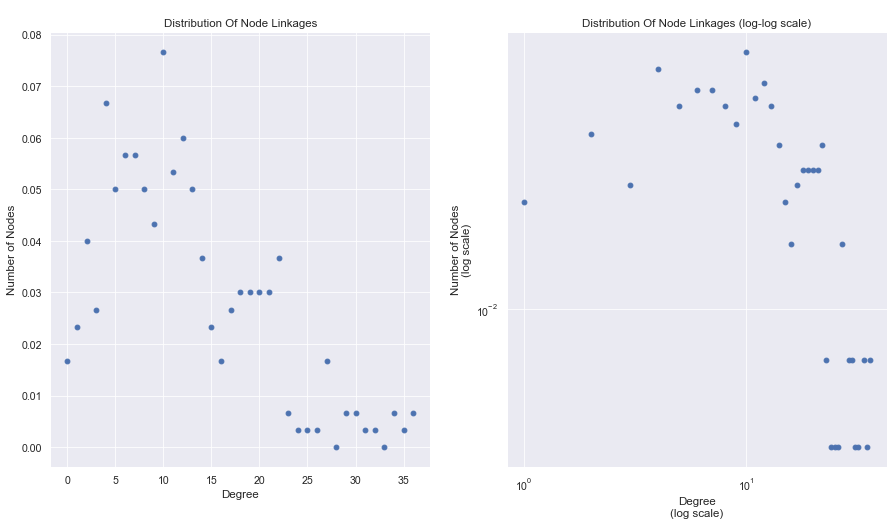

In [224]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_degree_histogram(g, normalized=True):
    
    aux_y = nx.degree_histogram(g)
    
    aux_x = np.arange(0,len(aux_y)).tolist()
    
    n_nodes = g.number_of_nodes()
    
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes
    
    return aux_x, aux_y

plt.subplot(1, 2, 1)
plt.title('\nDistribution Of Node Linkages')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')

aux_x, aux_y=plot_degree_histogram(G)
plt.plot(aux_x, aux_y, 'o')

plt.subplot(1, 2, 2)
plt.title('\nDistribution Of Node Linkages (log-log scale)')
plt.xlabel('Degree\n(log scale)')
plt.ylabel('Number of Nodes\n(log scale)')
plt.xscale("log")
plt.yscale("log")
aux_x, aux_y=plot_degree_histogram(G)
plt.plot(aux_x, aux_y, 'o')

plt.savefig('Images/degree_distribution.png')

In [15]:
print('the average degree <k> is: ', 2*G.number_of_edges() / float(G.number_of_nodes()))

the average degree <k> is:  11.72


Let's see who is the most common actor during these 30 years:

In [16]:
Actors=[]
for film in G.nodes(data=True):
    l=len(film[1]['Actors'])
    for n in range(0,l):
        Actors.append(film[1]['Actors'][n])
        
Actors
from collections import Counter
lista=Counter(Actors)
lista.most_common()

[('Gary Oldman', 13),
 ('Samuel L. Jackson', 12),
 ('Ian McKellen', 12),
 ('Tom Hanks', 11),
 ('Alan Rickman', 10),
 ('Robert Downey Jr.', 10),
 ('Maggie Smith', 9),
 ('Hugo Weaving', 9),
 ('Robbie Coltrane', 9),
 ('Emma Watson', 9),
 ('Orlando Bloom', 9),
 ('Andy Serkis', 9),
 ('Judi Dench', 8),
 ('Will Smith', 8),
 ('Daniel Radcliffe', 8),
 ('Rupert Grint', 8),
 ('Julie Walters', 8),
 ('Johnny Depp', 8),
 ('Scarlett Johansson', 8),
 ('Julia Roberts', 7),
 ('Harrison Ford', 7),
 ('Morgan Freeman', 7),
 ('Ralph Fiennes', 7),
 ('Stanley Tucci', 7),
 ('Cameron Diaz', 7),
 ('Gwyneth Paltrow', 7),
 ('Eddie Murphy', 7),
 ('Ian Holm', 7),
 ('Ben Stiller', 7),
 ('Cate Blanchett', 7),
 ('Christopher Lee', 7),
 ('Dwayne Johnson', 7),
 ('Helena Bonham Carter', 7),
 ('Don Cheadle', 7),
 ('Stellan Skarsgård', 7),
 ('Tyrese Gibson', 7),
 ('Robin Williams', 6),
 ('Mel Gibson', 6),
 ('Richard Griffiths', 6),
 ('Tom Cruise', 6),
 ('Keanu Reeves', 6),
 ('Pierce Brosnan', 6),
 ('Woody Harrelson', 6),
 (

### GARY OLDMAN IS THE MOST COMMON ACTOR IN THESE 30 YEARS

______

# 3. Tools, theory and analysis. Describe the process of theory to insight

In this first part of section 3, we will only recall what have been done so far, analysing all the issues related to reading wikipages: regex, unicode, etc..

After applying the method to extract the wiki pages for each year, the first problem came when you have to obtain the hyperlinks of the 10 films with highest gross: this is the first time in which you need to apply regular expressions:

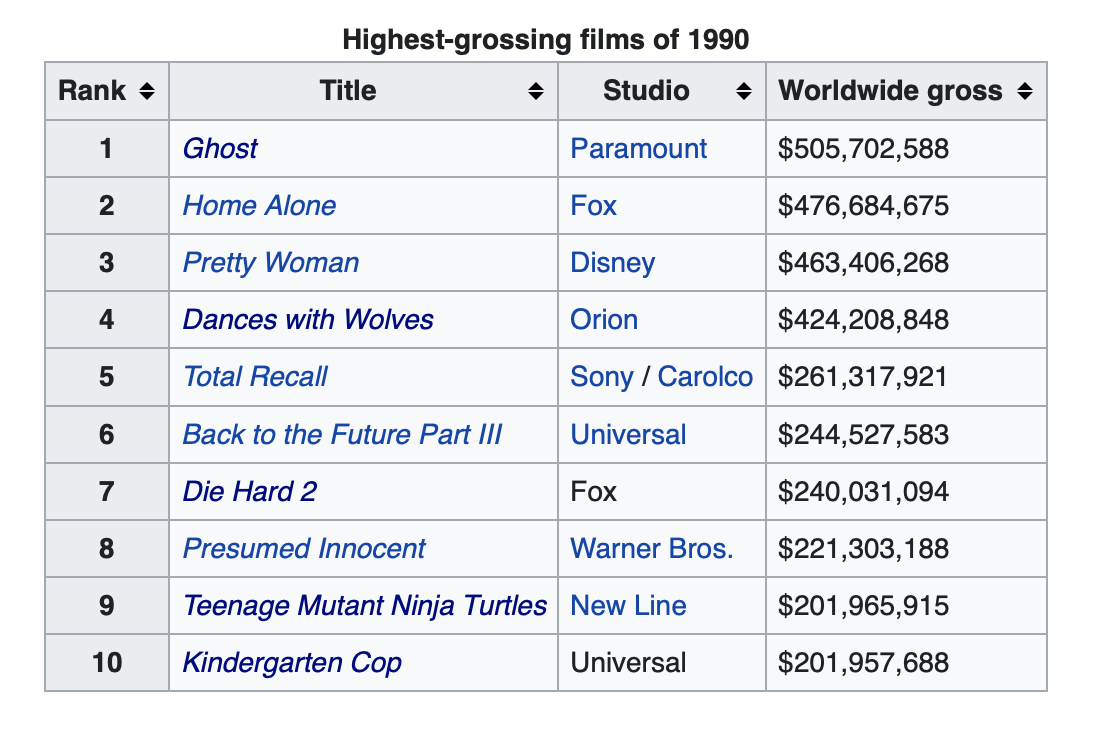

In [17]:

Image("./film1990.png")

If we look at the API, a pattern based on the number of the film can be found. That's why a loop between 1 and 10 is created and the pattern for the regex is:

```
for n in range(1,11):
            pattern="%s\\\\n\| \\\\'\\\\'\[\[(.*?)\]\]" % n
```

but, only for 2015 page the pattern changed to: 

```
pattern_2015="%s\\\\n\| scope=\"row\" style= \| \\\\'\\\\'\[\[(.*?)\]\]|%s\\\\n\| scope=\"row\" \| \\\\'\\\\'\[\[(.*?)\]\]" % (n,n)
            
```

___

The second issue came when we wanted to save each page of the film. There were films with problems about the unicode, here we did handle it working on the films because they were few films and a general solution was impossible to find even with hours of internet research. We can see that especially for Harry Potter pages we changed the name before searching for the page and then again we renamed it as it was before the search. 

Moreover there were films with a redirect pattern like this:

```
pattern_redirect='REDIRECT \[\[(.*?)\]\]'
```

where we needed to get the name inside the round brackets.

_____

The biggest issue with regex came when the actors and the director have to be extracted from the wikipage of each film: the main idea to extract them is _splitting_.

In what sense? This can be easier understood showing the API of the film Ghost:

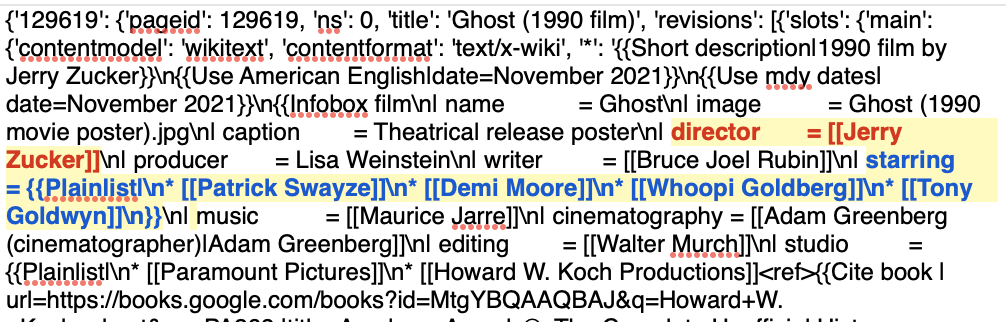

In [18]:
Image("./Ghost_api.png")

Almost all the wiki pages have this pattern both for director and actors.
<br>Splitting means that for director we took all the line after director, until the next \n:
```
(?<=director)(.*?)(?=\\n\|)
```

with this pattern we took everthing in red. After this, with another pattern, we get the information in between square brackets.
```
\[\[(.*?)(?:\|.*?)?\]\]
```

So in this case, we would get __Jerry Zucker__.

For actors the reasoning is basically the same, but here the main pattern is obviously different:
```
(?<=starring)(.*?)(?=\\n\|)
```

then we use:
```
\[\[(.*?)(?:\|.*?)?\]\]

```


With these patterns, we would get __Patrick Swayze__, __Demi Moore__, __Whoopi Goldberg__ and __Tony Goldwyn__.

Let's check it again:

In [19]:
G.nodes['Ghost (1990 film)']

{'year': 1990,
 'Director': ['Jerry Zucker'],
 'Actors': ['Patrick Swayze', 'Demi Moore', 'Whoopi Goldberg', 'Tony Goldwyn']}

**NOTE**: these are the general patterns, there are also films that don't follow these patterns and they have slightly different ones. These cases have been handled ad hoc as can be seen for example for Titanic that had a different pattern for the director.

______

__MAIN IDEA__
<br>The main idea is understanding the relationships between films and __Oscar winners__. So far, the information about films have been taken from the wiki page, but to get the information about Oscar, the kaggle dataset (https://www.kaggle.com/unanimad/the-oscar-award) has to be used. The info extracted from this dataset will be added to our nodes and further analysis on these will be done.

We now download the csv contained in this kaggle page:

In [20]:
oscar=pd.read_csv('the_oscar_award.csv')
oscar=oscar.dropna()

In [21]:
#WE ONLY NEED FILMS AFTER 1989
oscar=oscar[oscar.year_film>=1990]
oscar.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
6889,1990,1991,63,ACTOR IN A LEADING ROLE,Kevin Costner,Dances With Wolves,False
6890,1990,1991,63,ACTOR IN A LEADING ROLE,Robert De Niro,Awakenings,False
6891,1990,1991,63,ACTOR IN A LEADING ROLE,Gerard Depardieu,Cyrano de Bergerac,False
6892,1990,1991,63,ACTOR IN A LEADING ROLE,Richard Harris,The Field,False
6893,1990,1991,63,ACTOR IN A LEADING ROLE,Jeremy Irons,Reversal of Fortune,True


In the dataset there are all the oscar categories, as we can see here:

In [22]:
set(oscar['category'])

{'ACTOR IN A LEADING ROLE',
 'ACTOR IN A SUPPORTING ROLE',
 'ACTRESS IN A LEADING ROLE',
 'ACTRESS IN A SUPPORTING ROLE',
 'ANIMATED FEATURE FILM',
 'ART DIRECTION',
 'BEST PICTURE',
 'CINEMATOGRAPHY',
 'COSTUME DESIGN',
 'DIRECTING',
 'DOCUMENTARY (Feature)',
 'DOCUMENTARY (Short Subject)',
 'FILM EDITING',
 'FOREIGN LANGUAGE FILM',
 'INTERNATIONAL FEATURE FILM',
 'MAKEUP',
 'MAKEUP AND HAIRSTYLING',
 'MUSIC (Original Dramatic Score)',
 'MUSIC (Original Musical or Comedy Score)',
 'MUSIC (Original Score)',
 'MUSIC (Original Song)',
 'PRODUCTION DESIGN',
 'SHORT FILM (Animated)',
 'SHORT FILM (Live Action)',
 'SOUND',
 'SOUND EDITING',
 'SOUND EFFECTS EDITING',
 'SOUND MIXING',
 'SPECIAL ACHIEVEMENT AWARD (Visual Effects)',
 'VISUAL EFFECTS',
 'WRITING (Adapted Screenplay)',
 'WRITING (Original Screenplay)',
 'WRITING (Screenplay Based on Material Previously Produced or Published)',
 'WRITING (Screenplay Based on Material from Another Medium)',
 'WRITING (Screenplay Written Directly fo

The categories for actors and directors are differentiated. <br>For __actors__ only the first four are taken into account (ACTOR IN A LEADING ROLE',
 'ACTOR IN A SUPPORTING ROLE',
 'ACTRESS IN A LEADING ROLE',
 'ACTRESS IN A SUPPORTING ROLE'). <br>For __director__ only the category 'DIRECTING'.
 

In [23]:

actor_winners=[]
director_winners=[]
for node in G.nodes(data=True):
    
    actor_oscar=[]
    director_oscar=[]
    counter=0
    uu=re.sub("([\(\[]).*?([\)\]])", "", node[0])
    uu=uu.replace("\\", "")
    
    
   
    for category, name, film, winner, yf in zip(oscar.category, oscar.name, oscar.film, oscar.winner, oscar.year_film):

        if category== 'ACTOR IN A LEADING ROLE' or category== 'ACTOR IN A SUPPORTING ROLE' or category=='ACTRESS IN A LEADING ROLE' or category=='ACTRESS IN A SUPPORTING ROLE':
            
            if film in uu and yf==node[1]['year'] and winner==True :
                
                for actor in node[1]['Actors']:
                    if actor==name:
                        
                        actor_oscar.append(actor)
    
        elif category== 'DIRECTING':
            
            if film in uu and yf==node[1]['year'] and winner==True :
                
                for director in node[1]['Director']:
                    if director==name:
                        
                        director_oscar.append(director)
                        
        else:
            
            
            if film in uu and yf==node[1]['year'] and winner==True :
                
                counter=counter+1
    if len(actor_oscar)>0:        
        actor_winners.append(actor_oscar)  
    if len(director_oscar)>0:  
        director_winners.append(director_oscar[0])
    G.nodes[node[0]]['actors_oscar']=actor_oscar
    G.nodes[node[0]]['director_oscar']=director_oscar
    G.nodes[node[0]]['movies_oscar']=len(actor_oscar)+counter+len(director_oscar)
                

let's see how now each node looks:

In [24]:
G.nodes['Ghost (1990 film)']

{'year': 1990,
 'Director': ['Jerry Zucker'],
 'Actors': ['Patrick Swayze', 'Demi Moore', 'Whoopi Goldberg', 'Tony Goldwyn'],
 'actors_oscar': ['Whoopi Goldberg'],
 'director_oscar': [],
 'movies_oscar': 2}

We can check our result here: https://en.wikipedia.org/wiki/Ghost_(1990_film), Ghost won 2 oscars, one of this is the Best Supporting Actress for Whoopi Goldberg.

Another example:

In [25]:
G.nodes['The Lord of the Rings: The Return of the King']

{'year': 2003,
 'Director': ['Peter Jackson'],
 'Actors': ['Elijah Wood',
  'Ian McKellen',
  'Liv Tyler',
  'Viggo Mortensen',
  'Sean Astin',
  'Cate Blanchett',
  'John Rhys-Davies',
  'Bernard Hill',
  'Billy Boyd (actor)',
  'Dominic Monaghan',
  'Orlando Bloom',
  'Hugo Weaving',
  'Miranda Otto',
  'David Wenham',
  'Karl Urban',
  'John Noble',
  'Andy Serkis',
  'Ian Holm',
  'Sean Bean'],
 'actors_oscar': [],
 'director_oscar': ['Peter Jackson'],
 'movies_oscar': 11}

This film won 11 oscars, this is confirmed by the wikipage as well: https://en.wikipedia.org/wiki/The_Lord_of_the_Rings:_The_Return_of_the_King

Merging the Graph with the Oscar dataset seems to give reliable results.

In [26]:
# In the code above I've also saved all the directors and actors who won the oscar
print('These are the winning directors: ',director_winners)

These are the winning directors:  ['Jonathan Demme', 'Steven Spielberg', 'Robert Zemeckis', 'James Cameron', 'Steven Spielberg', 'Sam Mendes', 'Peter Jackson', 'Alfonso Cuarón']


In [27]:
# Let's count the director with the highest number of Oscars:
list_director=Counter(director_winners)
list_director.most_common()

[('Steven Spielberg', 2),
 ('Jonathan Demme', 1),
 ('Robert Zemeckis', 1),
 ('James Cameron', 1),
 ('Sam Mendes', 1),
 ('Peter Jackson', 1),
 ('Alfonso Cuarón', 1)]

WE SEE THAT THE ONLY ONE WINNING 2 OSCARS IS __SPIELBERG__.

In [28]:
# WE DO THE SAME FOR THE ACTOR TO SEE WHO WON MORE OSCARS
list_a=[]
for k in actor_winners:
    l=len(k)
    for i in range(0,l):
        list_a.append(k[i])
print('These are the winning ACTORS: ',list_a)

These are the winning ACTORS:  ['Whoopi Goldberg', 'Anthony Hopkins', 'Jodie Foster', 'Tommy Lee Jones', 'Tom Hanks', 'Tom Hanks', 'Jack Nicholson', 'Helen Hunt', 'Gwyneth Paltrow', 'Judi Dench', 'Kevin Spacey', 'Russell Crowe', 'Heath Ledger', 'Rami Malek', 'Joaquin Phoenix']


#### HERE WE HAVE THE ACTORS WITH MOST OSCARS

In [29]:
lista=Counter(list_a)

more_oscars_winner_actor=lista
more_oscars_winner_actor.most_common()

[('Tom Hanks', 2),
 ('Whoopi Goldberg', 1),
 ('Anthony Hopkins', 1),
 ('Jodie Foster', 1),
 ('Tommy Lee Jones', 1),
 ('Jack Nicholson', 1),
 ('Helen Hunt', 1),
 ('Gwyneth Paltrow', 1),
 ('Judi Dench', 1),
 ('Kevin Spacey', 1),
 ('Russell Crowe', 1),
 ('Heath Ledger', 1),
 ('Rami Malek', 1),
 ('Joaquin Phoenix', 1)]

## ONLY TOM HANKS WON 2 OSCARS

___

# WHICH IS THE FILM WITH MOST OSCAR?

To answer this question, a map has been created where each film (key) has the number of oscars as value. Then, the values is used to sort the map by the number of oscars.

In [30]:
film_map={}

for film in G.nodes(data=True):
    
    film_map[film[0]]=film[1]['movies_oscar']
    
sorted_film_map=dict(sorted(film_map.items(), key=lambda item: item[1] ,reverse=True))


In [31]:
sorted_film_map

{'Titanic (1997 film)': 11,
 'The Lord of the Rings: The Return of the King': 11,
 "Schindler\\'s List": 7,
 'Shakespeare in Love': 7,
 'Gravity (2013 film)': 7,
 'Forrest Gump': 6,
 'The Silence of the Lambs (film)': 5,
 'Saving Private Ryan': 5,
 'American Beauty (1999 film)': 5,
 'Gladiator (2000 film)': 5,
 'Terminator 2: Judgment Day': 4,
 'The Matrix': 4,
 'The Lord of the Rings: The Fellowship of the Ring': 4,
 'Inception': 4,
 'Bohemian Rhapsody (film)': 4,
 "Bram Stoker\\'s Dracula (1992 film)": 3,
 'Jurassic Park (film)': 3,
 'King Kong (2005 film)': 3,
 'Avatar (2009 film)': 3,
 'Black Panther (film)': 3,
 'Ghost (1990 film)': 2,
 'Aladdin (1992 Disney film)': 2,
 'Philadelphia (film)': 2,
 'The Lion King': 2,
 'Speed (1994 film)': 2,
 'Apollo 13 (film)': 2,
 'Pocahontas (1995 film)': 2,
 'As Good as It Gets': 2,
 'The Lord of the Rings: The Two Towers': 2,
 'The Incredibles': 2,
 'The Dark Knight (film)': 2,
 'Up (2009 film)': 2,
 'Toy Story 3': 2,
 'Alice in Wonderland (20

## Titanic (1997 film) and The Lord of the Rings: The Return of the King are the films with most oscars

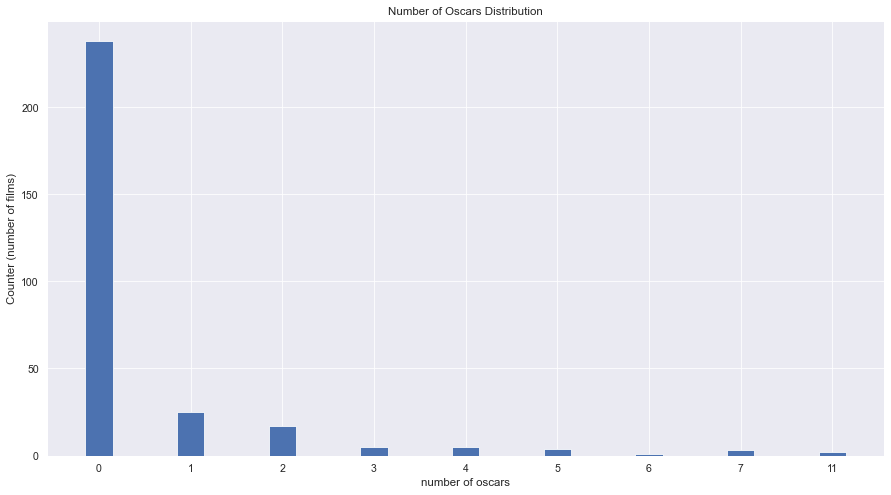

In [223]:
#Here there is the number of oscars distribution:
list_of_number_oscar=[]
sorted_reverse_film_map=dict(sorted(film_map.items(), key=lambda item: item[1] ,reverse=False))
for i in sorted_reverse_film_map.values():
    list_of_number_oscar.append(i)
    
labels, values = zip(*Counter(list_of_number_oscar).items())

indexes = np.arange(len(labels))
width = 0.3

plt.bar(indexes, values, width)
plt.xticks(indexes , labels)
plt.xlabel('number of oscars')
plt.ylabel('Counter (number of films)')
plt.title('Number of Oscars Distribution')
plt.savefig('Images/oscar-won.png')
plt.show()

Many of the films with highest gross didn't win any oscar!

___

## VISUALIZATION

So far, the graph has been analysed. But, let's try to visualize it through the force atlas package:
<br>**NODES COLOR**:
* yellow: if the movie won more than 3 oscars 
* green: if the movie won 1 or 2 oscars 
* purple: if the movie didn't win any oscar 

__EDGES COLOR__:
* black: if the movies share more than 5 actors 
* pink: if the movies share from 1 or 2 actors 
* blue: if the movie share 3 or 4 actors

100%|██████████| 2000/2000 [00:02<00:00, 705.12it/s]


BarnesHut Approximation  took  0.55  seconds
Repulsion forces  took  1.87  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.14  seconds


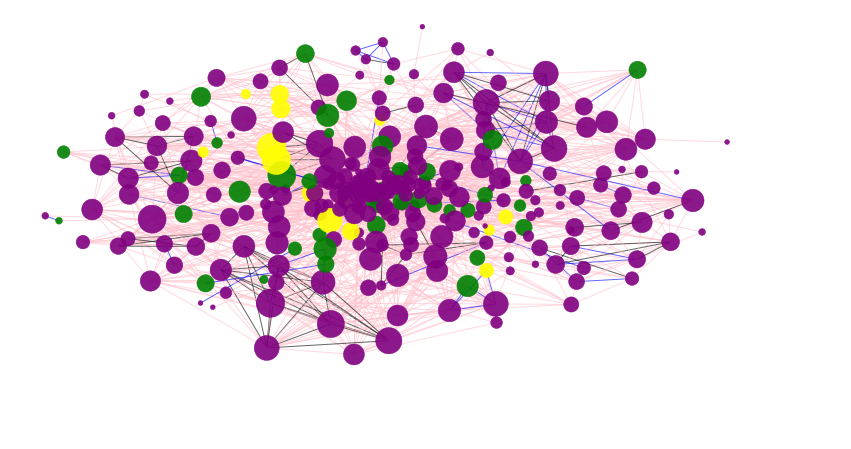

In [33]:
color_map = []
for node in G.nodes(data=True):
    
    oscar=node[1]['movies_oscar']
    if oscar > 3:
        color_map.append('yellow')
    elif oscar > 0 and oscar < 3: 
        color_map.append('green') 
    else: color_map.append('purple') 
        

        
        
edge_color= []

for edge in G.edges(data=True):
    
    
    if len(edge[2]['Actors']) >= 5:
        edge_color.append('black')
    elif len(edge[2]['Actors'])==1 or len(edge[2]['Actors'])==2:
        edge_color.append('pink')
    else: edge_color.append('blue')
        
        
   
        






d = dict(G.degree)

from fa2 import ForceAtlas2
import matplotlib.pyplot as plt

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        
                        outboundAttractionDistribution=False,
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=80.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, node_size=[v * 23 for v in d.values()],  node_color=color_map,  alpha=0.9)
nx.draw_networkx_edges(G, positions, edge_color=edge_color, alpha=0.6)
plt.axis('off')
plt.savefig('Images/network.png')
plt.show()

Many films just share 1 or 2 actors. But there are also enough films with more than 5 shared actors.

___

## WORD CLOUD

Through the word cloud, the popular terms for the first three films with most oscars number are analysed. The Scripts for these films are taken from this site: https://imsdb.com, which contains scripts for almost every film.

In [34]:
f = open('./Scripts/Lord_of_The_Rings.txt')
raw = f.read()

new_raw=re.sub('\=\=[\s\w]*\=\=','',raw)

eee = stopwords.words()
lemmatizer = WordNetLemmatizer()

list_s=[]

for i in eee:
    list_s.append(i)
    
tokenizer1 =  WordPunctTokenizer()
    
new_raw2=tokenizer1.tokenize(new_raw)
    
new_raw2=TreebankWordDetokenizer().detokenize(new_raw2)
    
    
tokenizer2 = nltk.RegexpTokenizer(r"\w+")
    
   
    
nopunc = tokenizer2.tokenize(new_raw2)
    
    


lower_words = [w.lower() for w in nopunc if w not in list_s]
    
clean = ' '.join([lemmatizer.lemmatize(w) for w in lower_words])

path2="./Tokens/"
    

g2="%s%s" % (path2, 'Lord_of_The_Rings.txt')
    
text_file = open(g2, "w")
n = text_file.write(clean)
text_file.close()

lord=PlaintextCorpusReader('./Tokens/', 'Lord_of_The_Rings.txt')      
corpus=nltk.Text(lord.words())

In [35]:
# Now we calculate term frequency and idf

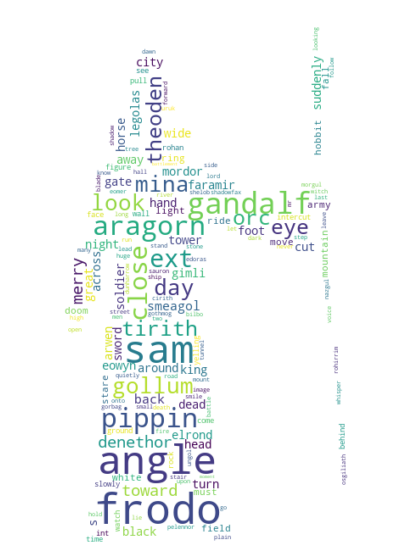

In [36]:
txt = nltk.Text(corpus)
l = len(txt)
tc = {}

               
for key, value in FreqDist(txt).items():
    #print(key,'   ', value)                
    tc[key] = value
    
    



txtLord = TextCollection(corpus)
idf = {}
for word in np.unique(corpus):
    
    idf[word] = txtLord.idf(word)
    



tcidf={}
for word, val in tc.items():
        tcidf[word] = val*idf[word]
        

        
text=''
for word, val in tcidf.items():
    new_string=''
    word=word+' '
    new_string=word*int(round(val,0))
    text=text+new_string
 


mask = np.array(Imagex.open('./gandalf.jpeg'))
wordcloud = WordCloud(collocations=False , background_color="white",max_words=150, mask=mask, width=mask.shape[1],
               height=mask.shape[0]).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('Images/wordcloud_lotr.png')
plt.show()

In [37]:
files=PlaintextCorpusReader('./Scripts/','schindlers-list.txt')      
corpus=nltk.Text(files.words())

In [38]:
f = open('./Scripts/schindlers-list.txt')
raw = f.read()
new_raw=re.sub('\=\=[\s\w]*\=\=','',raw)

tokenizer1 =  WordPunctTokenizer()
    
new_raw2=tokenizer1.tokenize(new_raw)
    
new_raw2=TreebankWordDetokenizer().detokenize(new_raw2)
    
    
tokenizer2 = nltk.RegexpTokenizer(r"\w+")
    
   
    
nopunc = tokenizer2.tokenize(new_raw2)
    
    


lower_words = [w.lower() for w in nopunc if w not in list_s]
    
clean = ' '.join([lemmatizer.lemmatize(w) for w in lower_words])

path2="./Tokens/"
    

g2="%s%s" % (path2, 'Schindlers_List.txt')
    
text_file = open(g2, "w")
n = text_file.write(clean)
text_file.close()

schindler=PlaintextCorpusReader('./Tokens/', 'Schindlers_List.txt')      
corpus=nltk.Text(schindler.words())




In [39]:
#HERE WE CALCULATE TF AND IDF

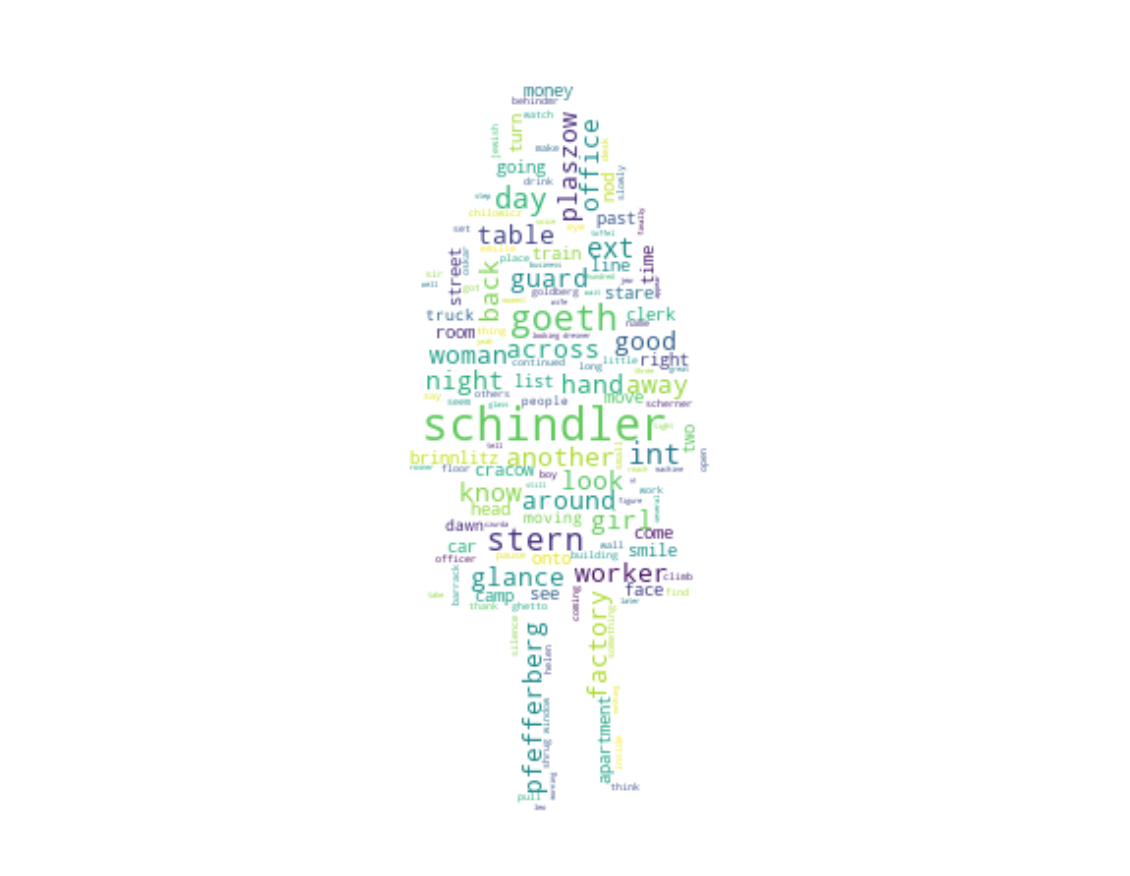

In [40]:
txt = nltk.Text(corpus)
l = len(txt)
tc = {}

               
for key, value in FreqDist(txt).items():
    #print(key,'   ', value)                
    tc[key] = value
    
    



txtschindler = TextCollection(corpus)
idf = {}
for word in np.unique(corpus):
    
    idf[word] = txtschindler.idf(word)
    



tcidf={}
for word, val in tc.items():
        tcidf[word] = val*idf[word]
        

        
text=''
for word, val in tcidf.items():
    new_string=''
    word=word+' '
    new_string=word*int(round(val,0))
    text=text+new_string


mask = np.array(Imagex.open('./schindler-removebg-preview-removebg-preview.jpg'))
wordcloud = WordCloud(collocations=False , background_color="white",max_words=150, mask=mask, width=mask.shape[1]*2,
               height=mask.shape[0]*2).generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('Images/wordcloud_schindler.png')
plt.show()

In [41]:
files=PlaintextCorpusReader('./Scripts/','titanic.txt')      
corpus=nltk.Text(files.words())

f = open('./Scripts/titanic.txt')
raw = f.read()

new_raw=re.sub('\=\=[\s\w]*\=\=','',raw)

tokenizer1 =  WordPunctTokenizer()
    
new_raw2=tokenizer1.tokenize(new_raw)
    
new_raw2=TreebankWordDetokenizer().detokenize(new_raw2)
    
    
tokenizer2 = nltk.RegexpTokenizer(r"\w+")
    
   
    
nopunc = tokenizer2.tokenize(new_raw2)
    
    


lower_words = [w.lower() for w in nopunc if w not in list_s]
    
clean = ' '.join([lemmatizer.lemmatize(w) for w in lower_words])

path2="./Tokens/"
    

g2="%s%s" % (path2, 'Titanic.txt')
    
text_file = open(g2, "w")
n = text_file.write(clean)
text_file.close()



Titanic=PlaintextCorpusReader('./Tokens/', 'Titanic.txt')      
corpus=nltk.Text(Titanic.words())

In [42]:
# tf, idf and word cloud

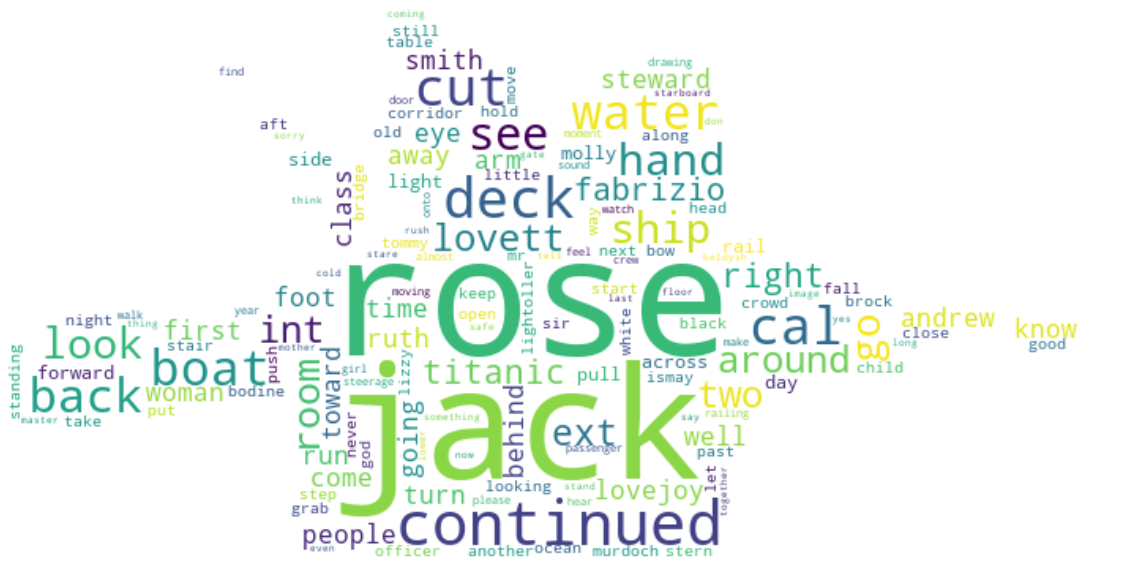

In [43]:
txt = nltk.Text(corpus)
l = len(txt)
tc = {}

               
for key, value in FreqDist(txt).items():
    #print(key,'   ', value)                
    tc[key] = value
    
    



txtTitanic = TextCollection(corpus)
idf = {}
for word in np.unique(corpus):
    
    idf[word] = txtTitanic.idf(word)
    



tcidf={}
for word, val in tc.items():
        tcidf[word] = val*idf[word]
        

        
text=''
for word, val in tcidf.items():
    new_string=''
    word=word+' '
    new_string=word*int(round(val,0))
    text=text+new_string
  

mask = np.array(Imagex.open('./titanic2.jpg'))
wordcloud = WordCloud(collocations=False , background_color="white",max_words=150, mask=mask, width=mask.shape[1]*2,
               height=mask.shape[0]*2).generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('Images/wordcloud_titanic.png')
plt.show()

## Sentiment Analysis - with VADER

First part of sentiment analysis we used the tool named VADER (Valence Aware Dictionary and sEntiment Reasoner) which is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains. Using VADER we give it a string of text, it outputs a score which is a decimal between 0 and 1 for negativity, positivity, and neutrality, as well compound score from -1 to 1 which is an aggregate measure.

#### How we used VADER

VADER works best with a short text or a sentence and to get this, regex was used to extract each sentence in the manuscript and by iterating over each sentence we get score for each sentence, then the sentence and score is added to a dataframe. The dataframe contains seven columns which are:
- Index, sentence, positivity score, negativity score, neutrality score, compound score and sentiment type.

The sentiment type is measured by compound score, the sentence is positive if compound score is more or equal with 0.05, it is negative if compound score is less or equal with -0.05 and if sentence is none of those it is neutral.

#### Plots

We have two plots showing result using VADER senitment analysis, the first is a plot that shows compound score throughout the movie and the second is a plot which counts sentiment type from column in dataframe.

The compound score plot was bit more complex, because a manuscript contains many sentences and therefore many data points and when plotting all the data points it becomes impossible to analyse how the compound score grows throughout the manuscript, therefore an alternativ was to find the average for a specific number of data points, to make it easier to see how the compund score grows. 

To do this the function *getIndexAndMeanValues(df, column, meanCount)* was created which takes a dataframe and column(score type) and number of sentences to calculate mean with as input, the function returns an index and average score, the index should be seen as the time throughout the movie, because the sentences are extracted from the beginning to the end of the manuscript, the function calculates mean for every *meanCount*(number) sentences and when there is a smaller amount of sentences than *meanCount* it will take the rest of sentences and calculate mean, the function stores the values in a list which are first index, last index and mean value, then the first value in the list will look like this if e.g. *meanCount* is 50 (in the sentiment analysis with VADER *meanCount* is set to 50):
- [0, 49, some decimal mean value]

Then we can use the first index and mean value to create a plot which shows compound score from the beginning of the manuscript to the end.

#### Why VADER?

We used VADER to see if all three movies would have the same pattern and by creating a plot with sentiment type and compound score, it was possible to see if they were alike or totally different. The conclusions are talked more about on the website.

#### Regex pattern

The manuscript for the movies does not have the same authors and therefore are not written the same way. For Lord of The Rings and Schindler's List is was possible to use the same regex pattern, but the pattern for Titanic had to be changed slightly.

Regex pattern for Lord of The Rings and Schindler's List:
- ([A-Z|a-z]+[a-z\'][^\][^\.!?]*[\.!?])

First character set contains rules are that it should be a letter in the alphabet both capital and lower case are allowed, following character set has to be an letter in alphabet in lower case and apostrophe is also allowed (only names of character which is speaking the sentence has capital letters and sometimes the first word in a sentence can be e.g. "it's" with apostrophe). Third character set is to not extract reverse slash (all sentences end with reverse slash). The last is to tell where sentence ends and it ends either by a dot, question mark or exclamation mark.

Regex pattern for Titanic:

- ([A-Z|a-z]+[a-z\'][^\(A-Z][^\.!?]*[\.!?])

The pattern for titanic is almost the same without the third chracter set, this is because the Titanic manuscript contains characters like (CONT'D) and (MORE) after a sentence and this should not be included in the sentence and that is what the third chracter set provides. 

**Functions**

In [44]:
# function input is a sentence 
# and function returns a dictionary with sentiment score from VADER
def getSentimentScore(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict;

In [45]:
# function input is compound score 
# and function uses compound score to check if sentiment type is positive, negative or neutral
def getSentimentType(compound):
    if compound >= 0.05 :
        return "Positive";
 
    elif compound <= - 0.05 :
        return "Negative";
 
    else :
        return "Neutral";

In [46]:
# function input is a list with sentences 
# and from list there is created a panda dataframe with sentiment scores
# and then the function returns the new dataframe
def getDfWithScores(sentences):
    list_with_scores = []
    for i in sentences:
        sentimentScore = getSentimentScore(i)
        sentimentType = getSentimentType(sentimentScore['compound'])
        list_with_scores.append([i, sentimentScore['pos'], sentimentScore['neg'], sentimentScore['neu'], sentimentScore['compound'], sentimentType])
        
    df = pd.DataFrame(list_with_scores, columns =['Sentence', 'Positive', 'Negative', 'Neutral', 'Compound', 'Sentiment Type'])
    return df;

In [130]:
# function input is dataframe and column, function then creates a list with mean values from chosen column
# mean value is calculated for every fifty values in column until there are not fifty values left,
# then the function creates mean with left values
def getIndexAndMeanValues(df, column, meanCount):
    list_of_means = []
    count = 0

    for indexNow in range(len(df)):
        count += 1

        if indexNow == 0:
            lastIndex = 0;

        if count == meanCount:
            mean_value = df.loc[lastIndex:indexNow, column].mean()
            list_of_means.append([lastIndex, indexNow, mean_value])
            lastIndex = indexNow
            count = 0
    else:
        mean_value = df.loc[lastIndex:indexNow, column].mean()
        list_of_means.append([lastIndex, indexNow, mean_value])
    
    rangeIndex = []
    score = []
    for i in list_of_means:
        rangeIndex.append(i[0])
        score.append(i[2])
    
    return rangeIndex, score;

### Lord of The Rings - Sentiment Score

In [48]:
f = open("./Scripts/Lord_of_The_Rings.txt", 'r');
# regex to find sentences in manuscript
sentences_lotr = re.findall('([A-Z|a-z]+[a-z\'][^\][^\.!?]*[\.!?])', f.read());
df_lotr = getDfWithScores(sentences_lotr);

**Dataframe**

In [49]:
df_lotr

,Sentence,Positive,Negative,Neutral,Compound,Sentiment Type
0,Screenplay By\\n\\n Fran ...,0.000,0.000,1.000,0.0000,Neutral
1,Tolkien\\n\\n Fin...,0.000,0.000,1.000,0.0000,Neutral
2,New Line Cinema Presents\\n\\n S...,0.249,0.000,0.751,0.6841,Positive
3,"and his cousin, DEAGOL, sit in a SMALL \\n ...",0.000,0.000,1.000,0.0000,Neutral
4,glinting off the surface of the water.,0.000,0.000,1.000,0.0000,Neutral
...,...,...,...,...,...,...
2940,he draws a deep breath:\\n\\n ...,0.231,0.000,0.769,0.2732,Positive
2941,I'm back.,0.000,0.000,1.000,0.0000,Neutral
2942,looks at his LOVELY FAMILY with GREAT HAPPINES...,0.507,0.124,0.370,0.9073,Positive
2943,and ROSIE take the CHILDREN'S HANDS and enter ...,0.000,0.000,1.000,0.0000,Neutral


### Schindler's List - Sentiment Score

In [50]:
f = open("./Scripts/schindlers-list.txt", 'r');
# regex to find sentences in manuscript
sentences_schin = re.findall('([A-Z|a-z]+[a-z\'][^\][^\.!?]*[\.!?])', f.read());
df_schin = getDfWithScores(sentences_schin);

**Dataframe**

In [51]:
df_schin

,Sentence,Positive,Negative,Neutral,Compound,Sentiment Type
0,SCHINDLER'S LIST\n\nScreenplay\nby\nSteven Zai...,0.095,0.000,0.905,0.3182,Positive
1,small depot set down against monotonous countr...,0.000,0.000,1.000,0.0000,Neutral
2,folding table on the wood- plank platform.,0.000,0.000,1.000,0.0000,Neutral
3,"Pens, ink well, forms.",0.412,0.000,0.588,0.2732,Positive
4,three year old girl holding the hand of woman ...,0.110,0.000,0.890,0.4939,Positive
...,...,...,...,...,...,...
3406,I'd like to pick up something for them.,0.263,0.000,0.737,0.3612,Positive
3407,It'll only take a minute.,0.000,0.000,1.000,0.0000,Neutral
3408,Their voices trace of the walking away\nfade.,0.000,0.000,1.000,0.0000,Neutral
3409,Against the empty hallway appears a faint imag...,0.000,0.091,0.909,-0.2023,Negative


### Titanic - Sentiment Score

In [52]:
f = open("./Scripts/titanic.txt", 'r');
# regex to find sentences in manuscript
sentences_titanic = re.findall('([A-Z|a-z]+[a-z\'][^\(A-Z][^\.!?]*[\.!?])', f.read());
df_titanic = getDfWithScores(sentences_titanic)

**Dataframe**

In [53]:
df_titanic

,Sentence,Positive,Negative,Neutral,Compound,Sentiment Type
0,"Then two faint lights appear, close together.",0.000,0.000,1.000,0.0000,Neutral
1,growing\nbrighter.,1.000,0.000,0.000,0.5106,Positive
2,"They resolve into two DEEP SUBMERSIBLES, fre...",0.442,0.084,0.474,0.7783,Positive
3,"One is ahead of the other, and passes close e...",0.098,0.000,0.902,0.3612,Positive
4,to follow it as it descends away into the ...,0.000,0.000,1.000,0.0000,Neutral
...,...,...,...,...,...,...
4351,At the bottom a man stands with his back to us.,0.000,0.000,1.000,0.0000,Neutral
4352,he turns and it is Jack.,0.000,0.000,1.000,0.0000,Neutral
4353,Smiling he holds his hand out toward us.,0.508,0.000,0.492,0.7351,Positive
4354,"Rose goes into his arms, a girl of 17.",0.000,0.000,1.000,0.0000,Neutral


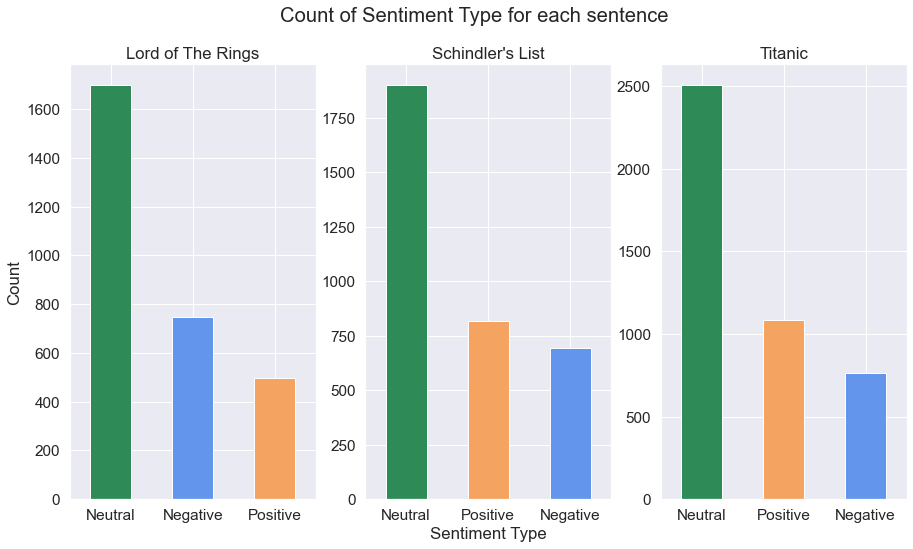

In [141]:
sns.set(font_scale = 1.4)
fig, axes = plt.subplots(1,3)
df_lotr['Sentiment Type'].value_counts().plot(rot=0, ylabel = "Count", kind = 'bar', ax=axes[0], color=['seagreen', 'cornflowerblue', 'sandybrown'])
df_schin['Sentiment Type'].value_counts().plot(rot=0, xlabel = "Sentiment Type", kind = 'bar', ax=axes[1], color=['seagreen', 'sandybrown', 'cornflowerblue'])
df_titanic['Sentiment Type'].value_counts().plot(rot=0, kind = 'bar', ax=axes[2], color=['seagreen', 'sandybrown', 'cornflowerblue'])
axes[0].set_title('Lord of The Rings')
axes[1].set_title("Schindler's List")
axes[2].set_title("Titanic")
fig.suptitle("Count of Sentiment Type for each sentence")
plt.savefig('Images/sentiment-type.png')

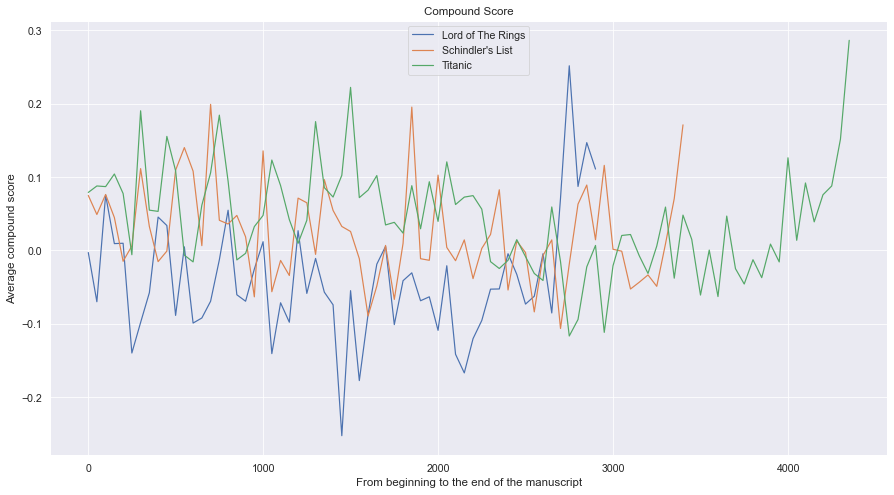

In [225]:
rangeIndex_lotr, score_lotr = getIndexAndMeanValues(df_lotr, 'Compound', 50)
plt.plot(rangeIndex_lotr, score_lotr, label="Lord of The Rings")

rangeIndex_schin, score_schin = getIndexAndMeanValues(df_schin, 'Compound', 50)
plt.plot(rangeIndex_schin, score_schin, label="Schindler's List")

rangeIndex_titanic, score_titanic = getIndexAndMeanValues(df_titanic, 'Compound', 50)
plt.plot(rangeIndex_titanic, score_titanic, label="Titanic")

plt.legend(loc='upper center')
plt.title("Compound Score")
plt.xlabel("From beginning to the end of the manuscript")
plt.ylabel("Average compound score")
plt.savefig('Images/compound-score.png')

## Sentiment Analysis - with Emotion Lexicon

For the next part with sentiment analysis we tried to use the tool NRCLexicon which is an MIT-approved pypi project by Mark M. Bailey which predicts the sentiments and emotion of a given text. The package contains approximately 27,000 words and is based on the National Research Council Canada (NRC) affect lexicon and the NLTK library’s WordNet synonym sets. NRCLexicon takes one word and gives it a score in ten different emotions, the emotions and sentiment which are measured is:
- Fear
- Anger
- Anticipation
- Trust
- Surprise
- Positive
- Negative
- Sadness
- Disgust
- Joy

#### How we used NRCLexicon and created the plot

From the word cloud part the manuscripts have been prepared for creating a word cloud, in this part we use the same files. NRCLexicon takes a word as an input and therefore we have created a function *getDataframeWithScores(filename)* which takes a filename as input and returns a dataframe with all the words in the manuscript and scores. Again this will give us many datapoints, more than in the VADER part because now each row is only one word, therefore we use the function *getIndexAndMeanValues(df, column, meanCount)* again, only this time *meanCount* is set to 400, to to get readable graphs. Then we created a plot with all ten emotions and in each plot we see how the graph grows for each movie, the plots are using a lot of space and therefore there are no x- and y-labels, but they are exactly the same as in the VADER compound score plot, x-label is from beginning to the end of movie and y-label is the score.

#### Why NRCLexicon?

This was an attempt to try and see if NRCLexicon would show any pattern of the emotions in the three movies, to see if there is some specific emotion to include in a movie that helps win an oscar award. NRCLexicon recognizes many different emotions which VADER doesn't, therefore this was an interesting tool to try and use on these three movies. The conclusions are talked more about on the website.

**Function**

In [6]:
def getDataframeWithScores(filename):
    manuscript = []
    f = open(filename, "r")
    for line in f:
        for word in line.split():
            manuscript.append(word)
            
    # create dataframe
    list_scores = []
    for i in range(len(manuscript)):
        emotion = NRCLex(manuscript[i])
        emotionAF = emotion.affect_frequencies
        list_scores.append([manuscript[i], emotionAF['fear'], emotionAF['anger'], emotionAF['anticip'], emotionAF['trust'], emotionAF['surprise'], emotionAF['positive'], emotionAF['negative'], emotionAF['sadness'], emotionAF['disgust'], emotionAF['joy']])

    df = pd.DataFrame(list_scores, columns =['Sentence', 'Fear', 'Anger', 'Anticip', 'Trust', 'Surprise', 'Positive', 'Negative', 'Sadness', 'Disgust', 'Joy'])
    return df

**Dataframes for Lord of The Rings, Schindler's List and Titanic**

In [124]:
df_l = getDataframeWithScores('./Tokens/Lord_of_The_Rings.txt')

In [125]:
df_s = getDataframeWithScores('./Tokens/Schindlers_List.txt')

In [7]:
df_t = getDataframeWithScores('./Tokens/Titanic.txt')

**An example how the dataset looks like**

In [8]:
df_t

,Sentence,Fear,Anger,Anticip,Trust,Surprise,Positive,Negative,Sadness,Disgust,Joy
0,1,0.000000,0.0,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.00
1,blackness,0.333333,0.0,0.0,0.00,0.00,0.00,0.333333,0.333333,0.0,0.00
2,1,0.000000,0.0,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.00
3,then,0.000000,0.0,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.00
4,two,0.000000,0.0,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
28168,smile,0.000000,0.0,0.0,0.25,0.25,0.25,0.000000,0.000000,0.0,0.25
28169,applaud,0.000000,0.0,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.00
28170,utter,0.000000,0.0,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.00
28171,silence,0.000000,0.0,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.00


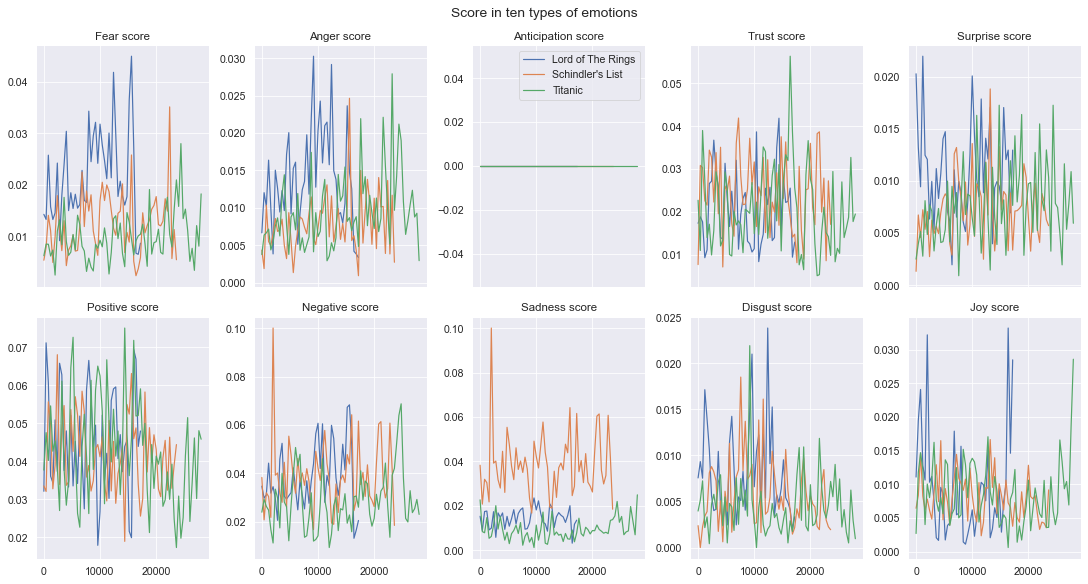

In [227]:
fig, axs = plt.subplots(2, 5, constrained_layout=True, sharex=True)
sns.set_context('paper', font_scale=1.2)

fig.suptitle("Score in ten types of emotions")

rangeIndex_lotr_fear, score_lotr_fear = getIndexAndMeanValues(df_l, 'Fear', 400)
axs[0, 0].plot(rangeIndex_lotr_fear, score_lotr_fear, label="Lord of The Rings")
rangeIndex_schin_fear, score_schin_fear = getIndexAndMeanValues(df_s, 'Fear', 400)
axs[0, 0].plot(rangeIndex_schin_fear, score_schin_fear, label="Schindler's List")
rangeIndex_titanic_fear, score_titanic_fear = getIndexAndMeanValues(df_t, 'Fear', 400)
axs[0, 0].plot(rangeIndex_titanic_fear, score_titanic_fear, label="Titanic")
axs[0, 0].set_title('Fear score')

rangeIndex_lotr_anger, score_lotr_anger = getIndexAndMeanValues(df_l, 'Anger', 400)
axs[0, 1].plot(rangeIndex_lotr_anger, score_lotr_anger, label="Lord of The Rings")
rangeIndex_schin_anger, score_schin_anger = getIndexAndMeanValues(df_s, 'Anger', 400)
axs[0, 1].plot(rangeIndex_schin_anger, score_schin_anger, label="Schindler's List")
rangeIndex_titanic_anger, score_titanic_anger = getIndexAndMeanValues(df_t, 'Anger', 400)
axs[0, 1].plot(rangeIndex_titanic_fear, score_titanic_anger, label="Titanic")
axs[0, 1].set_title('Anger score')

rangeIndex_lotr_Anticip, score_lotr_Anticip = getIndexAndMeanValues(df_l, 'Anticip', 400)
axs[0, 2].plot(rangeIndex_lotr_Anticip, score_lotr_Anticip, label="Lord of The Rings")
rangeIndex_schin_Anticip, score_schin_Anticip = getIndexAndMeanValues(df_s, 'Anticip', 400)
axs[0, 2].plot(rangeIndex_schin_Anticip, score_schin_Anticip, label="Schindler's List")
rangeIndex_titanic_Anticip, score_titanic_Anticip = getIndexAndMeanValues(df_t, 'Anticip', 400)
axs[0, 2].plot(rangeIndex_titanic_Anticip, score_titanic_Anticip, label="Titanic")
axs[0, 2].set_title('Anticipation score')

rangeIndex_lotr_Trust, score_lotr_Trust = getIndexAndMeanValues(df_l, 'Trust', 400)
axs[0, 3].plot(rangeIndex_lotr_Trust, score_lotr_Trust, label="Lord of The Rings")
rangeIndex_schin_Trust, score_schin_Trust = getIndexAndMeanValues(df_s, 'Trust', 400)
axs[0, 3].plot(rangeIndex_schin_Trust, score_schin_Trust, label="Schindler's List")
rangeIndex_titanic_Trust, score_titanic_Trust = getIndexAndMeanValues(df_t, 'Trust', 400)
axs[0, 3].plot(rangeIndex_titanic_Trust, score_titanic_Trust, label="Titanic")
axs[0, 3].set_title('Trust score')

rangeIndex_lotr_Surprise, score_lotr_Surprise = getIndexAndMeanValues(df_l, 'Surprise', 400)
axs[0, 4].plot(rangeIndex_lotr_Surprise, score_lotr_Surprise, label="Lord of The Rings")
rangeIndex_schin_Surprise, score_schin_Surprise = getIndexAndMeanValues(df_s, 'Surprise', 400)
axs[0, 4].plot(rangeIndex_schin_Surprise, score_schin_Surprise, label="Schindler's List")
rangeIndex_titanic_Surprise, score_titanic_Surprise = getIndexAndMeanValues(df_t, 'Surprise', 400)
axs[0, 4].plot(rangeIndex_titanic_Surprise, score_titanic_Surprise, label="Titanic")
axs[0, 4].set_title('Surprise score')

rangeIndex_lotr_Positive, score_lotr_Positive = getIndexAndMeanValues(df_l, 'Positive', 400)
axs[1, 0].plot(rangeIndex_lotr_Positive, score_lotr_Positive, label="Lord of The Rings")
rangeIndex_schin_Positive, score_schin_Positive = getIndexAndMeanValues(df_s, 'Positive', 400)
axs[1, 0].plot(rangeIndex_schin_Positive, score_schin_Positive, label="Schindler's List")
rangeIndex_titanic_Positive, score_titanic_Positive = getIndexAndMeanValues(df_t, 'Positive', 400)
axs[1, 0].plot(rangeIndex_titanic_Positive, score_titanic_Positive, label="Titanic")
axs[1, 0].set_title('Positive score')

rangeIndex_lotr_Negative, score_lotr_Negative = getIndexAndMeanValues(df_l, 'Negative', 400)
axs[1, 1].plot(rangeIndex_lotr_Negative, score_lotr_Negative, label="Lord of The Rings")
rangeIndex_schin_Negative, score_schin_Negative = getIndexAndMeanValues(df_s, 'Negative', 400)
axs[1, 1].plot(rangeIndex_schin_Negative, score_schin_Negative, label="Schindler's List")
rangeIndex_titanic_Negative, score_titanic_Negative = getIndexAndMeanValues(df_t, 'Negative', 400)
axs[1, 1].plot(rangeIndex_titanic_Negative, score_titanic_Negative, label="Titanic")
axs[1, 1].set_title('Negative score')

rangeIndex_lotr_Sadness, score_lotr_Sadness = getIndexAndMeanValues(df_l, 'Sadness', 400)
axs[1, 2].plot(rangeIndex_lotr_Sadness, score_lotr_Sadness, label="Lord of The Rings")
rangeIndex_schin_Sadness, score_schin_Sadness = getIndexAndMeanValues(df_s, 'Sadness', 400)
axs[1, 2].plot(rangeIndex_schin_Negative, score_schin_Negative, label="Schindler's List")
rangeIndex_titanic_Sadness, score_titanic_Sadness = getIndexAndMeanValues(df_t, 'Sadness', 400)
axs[1, 2].plot(rangeIndex_titanic_Sadness, score_titanic_Sadness, label="Titanic")
axs[1, 2].set_title('Sadness score')

rangeIndex_lotr_Disgust, score_lotr_Disgust = getIndexAndMeanValues(df_l, 'Disgust', 400)
axs[1, 3].plot(rangeIndex_lotr_Disgust, score_lotr_Disgust, label="Lord of The Rings")
rangeIndex_schin_Disgust, score_schin_Disgust = getIndexAndMeanValues(df_s, 'Disgust', 400)
axs[1, 3].plot(rangeIndex_schin_Disgust, score_schin_Disgust, label="Schindler's List")
rangeIndex_titanic_Disgust, score_titanic_Disgust = getIndexAndMeanValues(df_t, 'Disgust', 400)
axs[1, 3].plot(rangeIndex_titanic_Disgust, score_titanic_Disgust, label="Titanic")
axs[1, 3].set_title('Disgust score')

rangeIndex_lotr_Joy, score_lotr_Joy = getIndexAndMeanValues(df_l, 'Joy', 400)
axs[1, 4].plot(rangeIndex_lotr_Joy, score_lotr_Joy, label="Lord of The Rings")
rangeIndex_schin_Joy, score_schin_Joy = getIndexAndMeanValues(df_s, 'Joy', 400)
axs[1, 4].plot(rangeIndex_schin_Joy, score_schin_Joy, label="Schindler's List")
rangeIndex_titanic_Joy, score_titanic_Joy = getIndexAndMeanValues(df_t, 'Joy', 400)
axs[1, 4].plot(rangeIndex_titanic_Joy, score_titanic_Joy, label="Titanic")
axs[1, 4].set_title('Joy score')

axs[0,2].legend(loc="upper right")

plt.savefig('Images/score.png')

___

# 4. Discussion. Think critically about your creation

## What went well?

The movie for the project was created with iMovie, which was a tool never used before. It was fun and challenging to try and use, but overall it went really well creating the movie.
For the website we used a very popular platform named wix.com which went well and resulted in a beautiful outcome, even though we never had used wix.com before. We chose to use wix.com because we wanted to create a cool and innovative website, which makes it a bit more fun and interesting to look at while reading about our project.

The first part of the project(about reading wiki pages), was all about understanding the wiki pattern and extract through regular expressions what we needed. After that, we only have been careful on the particular cases: some wiki page didn't respect the usual pattern. For the statistics part, it was pretty easy cause we already worked with stats in the past projects. Same reasoning is applied to the Visualization and Word Cloud part. The thoughest part was merging the created graph, with the dataset of the oscar. It was easy to imagine that wiki pages have names and still the name in the oscar dataset where different sometime. After spending time trying to clean both the name, we think we reach a good result with this difficult merge.

For the sentiment analysis part we chose to use VADER and NRCLexicon, for the VADER part we used the original uncleaned manuscript to extract sentences with regex patterns. Using regex on the manuscript was time consuming, not because of the regex pattern, but because we had to use time looking through all the three manuscripts to understand how the manuscript were written, to get the optimal result when extracting each sentence. The resulting outcome was okay, but could have been done a bit better.
We have already worked with VADER which made the part a bit easier, the hard part was to find out how to create a plot with the many data points that made sense and which answered the questions we had, but with the help from the internet and other peoples ideas we were able to put together our own solution. The NRCLexicon tool was something we never had used before and which recognizes many different emotions. We used NRCLexicon to analyze each word in the manuscript which resulted in more data points than with the VADER part, therefore it was quite complex to find out how to display all the different emotions in a plot which made sense. Overall the sentiment analysis gave us the result we needed to look at the patterns in the manuscript. 

## What is still missing? What could be improved? Why?

This is the main point of this project: highest gross films not always receive Oscar awards. We lost a lot of oscar winners because of this. One example could be the film __PARASITE__, which won 4 oscars in 2019. This film is not in the movies with the highest gross, so we didn't have it in our graph. Both for needs of the course (we can only use wiki pages as primary source) and for make our work easier, we knew that this one would have been a issue, we did our consideration just on the base of the wiki pages that we found relevant for our aim. This project does not aim to be precise on everything, but just to have a quick idea on the relationship between __movies__, __actors__ and __oscars__. 

As mentioned we used the original uncleaned manuscript to extract sentences for VADER, it could have been imrpoved by cleaning the manuscript before using regex pattern to extract sentences. If we look at the sentences in the dataset the sentences contains characters like new line and reverse slash, which should have been removed.
With the NRCLexicon we used manuscript which was cleaned from the word cloud part and only containing the words, but it could have been improved by removing numbers in it.

In sentiment analysis we could have used more than three movies to find out if the movies had similiar patterns, it could have given us a better result, obviously more data more results. If we had more than three movies we could if it exist have found the average pattern in VADER compound score and emotions for movies winning most oscar awards, but with only three movies there is a big chance we won't find any pattern. As mentioned in our project we only used ten highest grossing movies resulting with many movies not winning any oscar award, therefore in our opinion the sentiment analysis would have gotten better results if we had used all movies between 1990 - 2019.

To be precise there is only one of the end goals we didn't reach and that was to check which genre had won most oscars, but because there was no regex pattern to extract the genre from wikipedia we did not get the genre in our dataset and therefore were not able to answer the question. There is probably some workaround which could have been used to get the genre, but the plan was to skip it at first and then later if there was time, try again to find some solution, but there was no time left for this. Overall in our opinion we reached the goals we wanted to and answered almost every question we asked, but there are always details which could have been improved and some of them we have mentioned above.

# 5. Contributions. Who did what?

Table below shows the main responsable of each part.

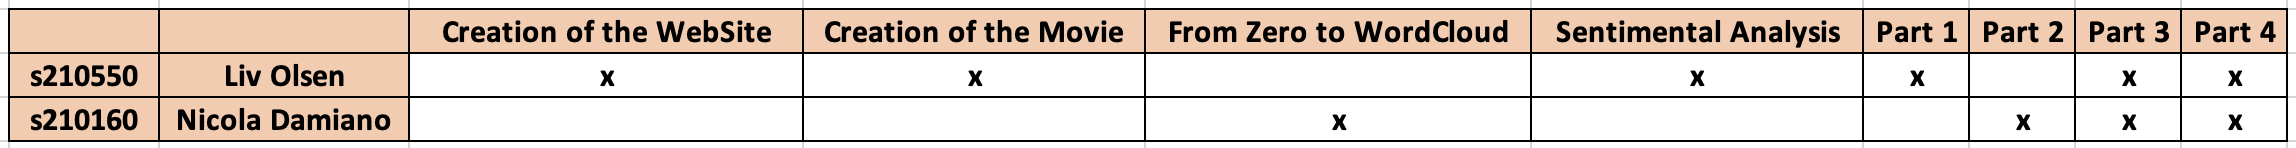

In [44]:
Image("./contribution_table.png")